### 분류 모형의 정확도를 평가하기 위한 Precision-Recall curve

- precision(정밀도)과 recall(재현율) 간의 절충점을 보여주는 그래프
- 곡선 아래의 면적 : ACU-PR (곡선 아래의 면적이 클수록 좋은 모형)
- ROC 커브는 0.5에서 점차 증가하여 1에 도달하지만, PR 커브는 1.0에서 점차 줄어드는 형태

In [2]:
import pandas as pd
df = pd.read_csv('../data/soccer/player.csv')
df.columns

Index(['id', 'player_name', 'birthday', 'preferred_foot', 'age', 'height',
       'weight', 'potential', 'right_foot', 'left_foot', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
       'overall_rating', 'Label'],
      dtype='object')

In [3]:
cols=[ 'age', 'height', 'weight', 'potential', 'right_foot', 
      'left_foot', 'crossing','finishing', 'heading_accuracy', 
      'short_passing', 'volleys','dribbling', 'curve', 'free_kick_accuracy', 
      'long_passing','ball_control', 'acceleration', 'sprint_speed', 'agility', 
      'reactions','balance', 'shot_power', 'jumping', 'stamina', 'strength', 
      'long_shots','aggression', 'interceptions', 'positioning', 'vision', 
      'penalties','marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
      'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
X=df[cols]
y=df['Label']
y.value_counts()

1    5705
0    5230
Name: Label, dtype: int64

Precision-Recall curve는 주로 불균형 데이터셋의 정밀도와 재현율을 측정하는 지표로 사용되므로, 여기서는 샘플링 과정을 생략함

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8748, 39), (2187, 39), (8748,), (2187,))

<AxesSubplot:>

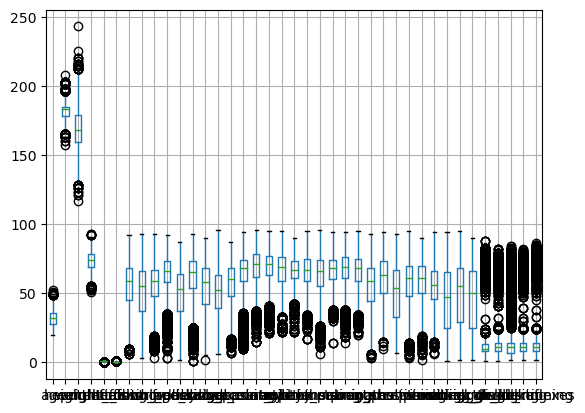

In [5]:
X_train.boxplot()

In [6]:
from sklearn.preprocessing import RobustScaler # 중앙값(median) 0, IQR(interquartile range, Q3-Q1) 1이 되도록 변환
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

<AxesSubplot:>

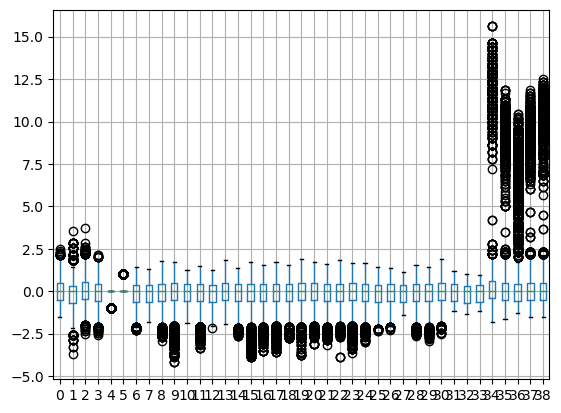

In [13]:
X_train_scaled.boxplot()

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
# svm 모형은 데이터의 양이 많을 경우 많은 메모리를 사용하여 속도가 매우 느려질 수 있으므로, BaggingClassifier를 사용하는 것을 권장함
# 1개의 기계학습모형이지만 데이터 샘플을 중복사용하여 서로 다른 결과를 출력하는 다수의 모형을 비교

svm = SVC()
n_estimators = 10
model = BaggingClassifier(base_estimator=svm,
                          n_estimators=n_estimators,
                          max_samples=1/n_estimators,
                          n_jobs=-1)
model.fit(X_train_scaled, y_train)
print("학습용 : ", model.score(X_train_scaled, y_train))
print("검증용 : ", model.score(X_test_scaled, y_test))

학습용 :  0.9229538180155464
검증용 :  0.9204389574759945


In [9]:
from sklearn.metrics import classification_report
pred = model.predict(X_test_scaled)
print(classification_report(y_test, pred))

y_score = model.decision_function(X_test_scaled)
y_score

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1046
           1       0.92      0.93      0.92      1141

    accuracy                           0.92      2187
   macro avg       0.92      0.92      0.92      2187
weighted avg       0.92      0.92      0.92      2187



array([-0.33939308,  2.55002053,  0.92365585, ...,  2.92638722,
       -0.61724651, -0.86959381])

In [10]:
# 판별 함수값으로 구한 precision 평균 점수
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_score)

0.9813274363023986

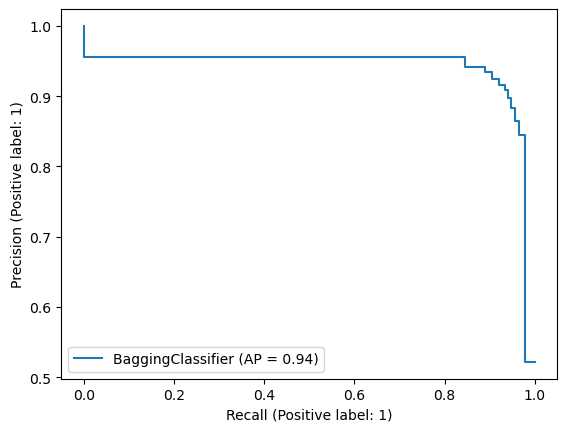

In [12]:
%matplotlib inline
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)